In [1]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from stingray.pulse import epoch_folding_search
from stingray.pulse import get_orbital_correction_from_ephemeris_file
import Important_Functions as IF
import scipy.stats as st
from importlib import reload

/opt/anaconda3/envs/testenv/lib/python3.10/site-packages/stingray/utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/opt/anaconda3/envs/testenv/lib/python3.10/site-packages/stingray/utils.py:40: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


In [2]:
#To reload functions - Keep in mind !
reload(IF)

<module 'Important_Functions' from '/Users/samsonmercier/Desktop/UNIGE/ap-lab-i-2022/notebooks/Important_Functions.py'>

## Importing data

In [108]:
#Retrieving data for source file
Time_phase_file = pf.open('sourceA.evt')

#Getting event arrival time data
Time_phase_data=Time_phase_file[1].data

## Getting GTIs

In [109]:
new_gti = IF.get_GTIs(Time_phase_file[2])

## Getting the event arrival times taking into account the orbital correction

In [110]:
#Setting up the parameters used by the Stingray documentation to correct the event arrival times
correct_orbital_time = IF.get_orbital_correction(Time_phase_file[1], 'orbit_t2.txt')

2022-10-23 17:47:20.945 | DEBUG    | pint.toa:__init__:1310 - No pulse number flags found in the TOAs
2022-10-23 17:47:20.945 | DEBUG    | pint.toa:compute_TDBs:2139 - Computing TDB columns.
2022-10-23 17:47:20.946 | DEBUG    | pint.toa:compute_TDBs:2164 - Using EPHEM = DE405 for TDB calculation.
2022-10-23 17:47:21.016 | DEBUG    | pint.toa:compute_posvels:2255 - Computing PosVels of observatories and Earth, using DE405
2022-10-23 17:47:21.024 | DEBUG    | pint.toa:compute_posvels:2310 - SSB obs pos [0. 0. 0.] m
2022-10-23 17:47:21.506 | INFO     | pint.solar_system_ephemerides:_load_kernel_link:54 - Set solar system ephemeris to de405 from download
2022-10-23 17:47:21.538 | DEBUG    | pint.toa:compute_posvels:2324 - Adding columns ssb_obs_pos ssb_obs_vel obs_sun_pos
2022-10-23 17:47:21.583 | DEBUG    | pint.models.solar_system_shapiro:solar_system_shapiro_delay:102 - Skipping Shapiro delay for Barycentric TOAs


## Using the event arrival times with orbital correction and the Stingray function epoch_folding_search to find pulse frequency

In [111]:
correct_list, guess_freq = IF.get_pulse_freq(0.208, 0.209, 1000, correct_orbital_time, new_gti, 20000)

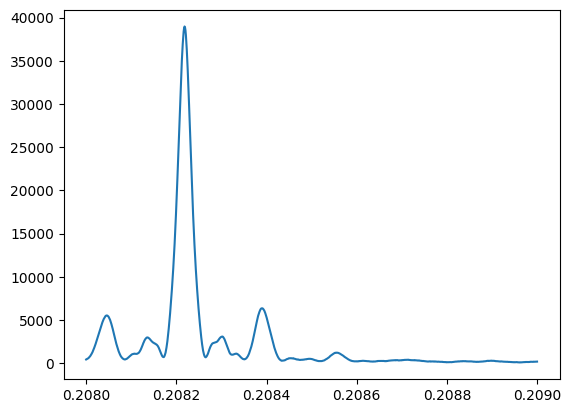

In [112]:
#Plotting the power as a function energy
plt.plot(correct_list[0], correct_list[1])
plt.show()

# Getting the pulse profile matrix with orbitally corrected time segments

## Segmenting data

In [113]:
reload(IF)
number_segments = 30
time_seg, PI_seg = IF.segment_time(Time_phase_data['PI'], correct_orbital_time, number_segments)

## Get the periodogram for the segments

In [114]:
freq_seg, power_seg = IF.get_power_and_freq(time_seg, PI_seg, number_segments)

## Getting the first harmonic frequencies and regression coefficients

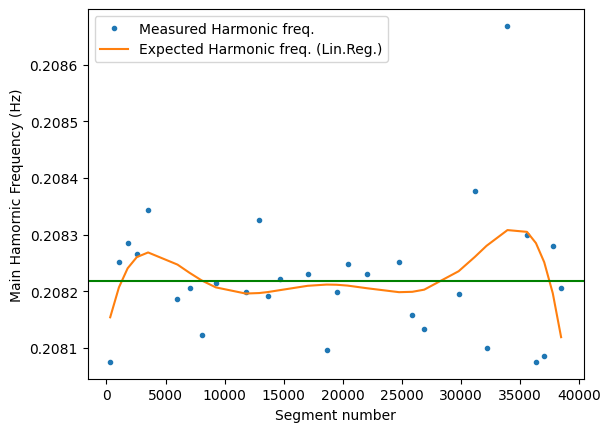

In [115]:
reload(IF)
reg, bins = IF.Harmonic_funk(6, 0.01, Time_phase_data['TIME'][0], time_seg, freq_seg, power_seg, guess_freq)

## Getting the pulse profile matrix

16
11
7
7
4
13
9
12
9
5
6
2
9
3
5
11
9
11
4
5
9
9
6
6
10
7
6
6
6
6


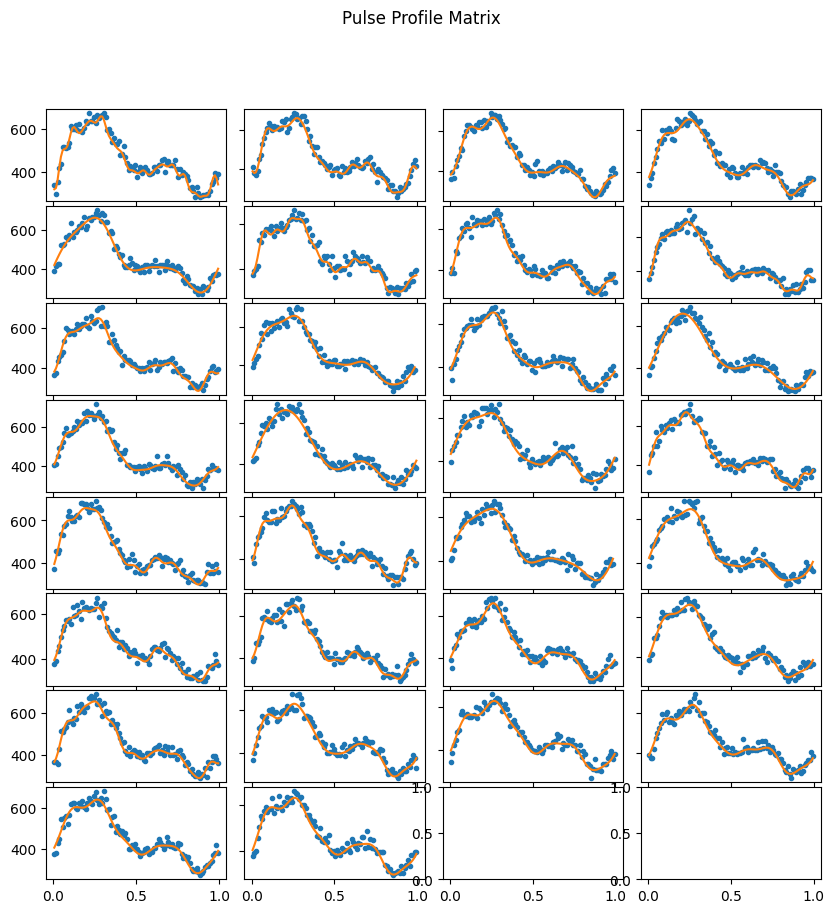

In [116]:
reload(IF)
orders, model_phases, counts, phasefolded_time = IF.pulse_profile_matrix(time_seg, Time_phase_data['TIME'][0], [guess_freq], 'Pulse Profile Matrix')



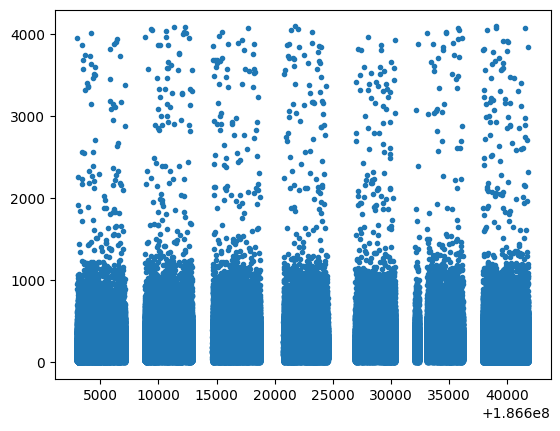

In [117]:
plt.plot(Time_phase_data['TIME'], Time_phase_data['PI'], '.')

# Getting the ENERGY pulse profile matrix

In [118]:
reload(IF)
num_segments = -22
E_min = 120
E_max = 950
energy_time_segments, energy_segments = IF.segment_energywise(correct_orbital_time, 
                                                              Time_phase_data['PI'], E_min, E_max, num_segments)



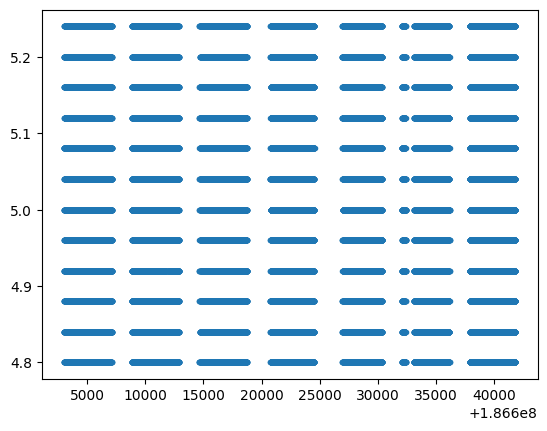

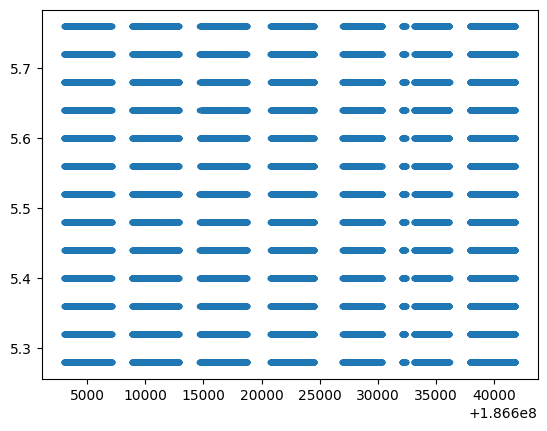

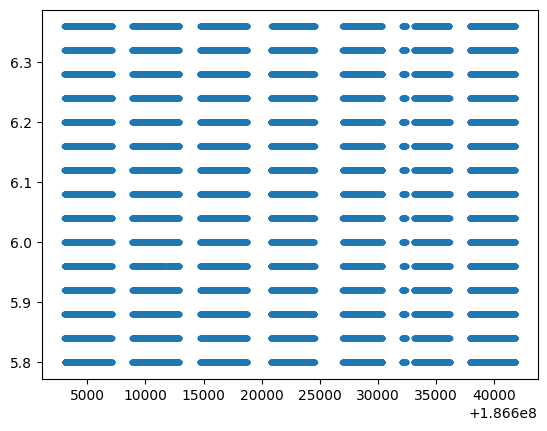

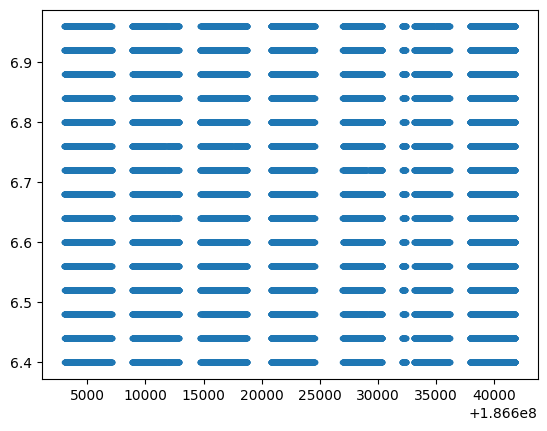

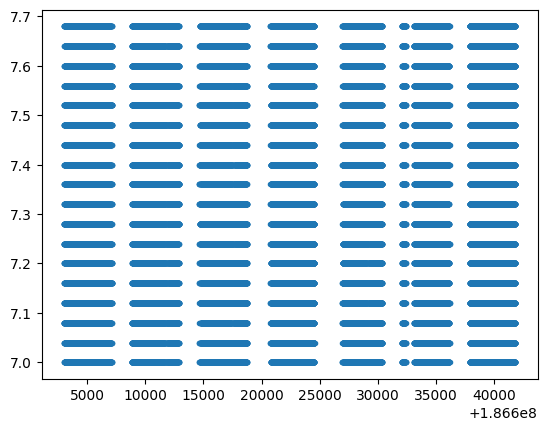

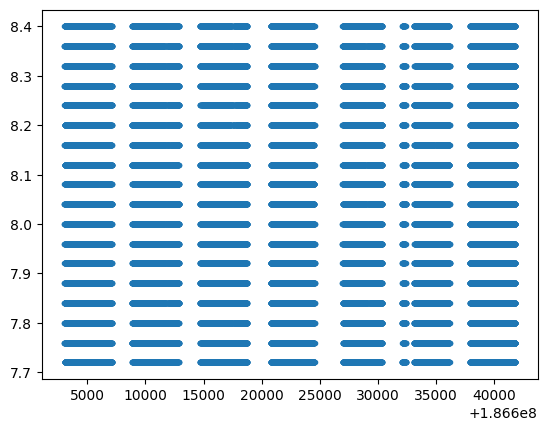

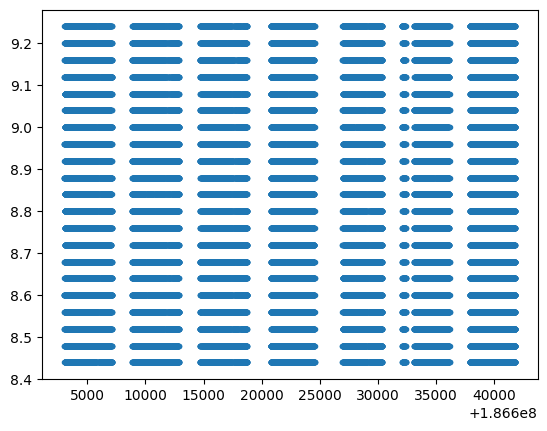

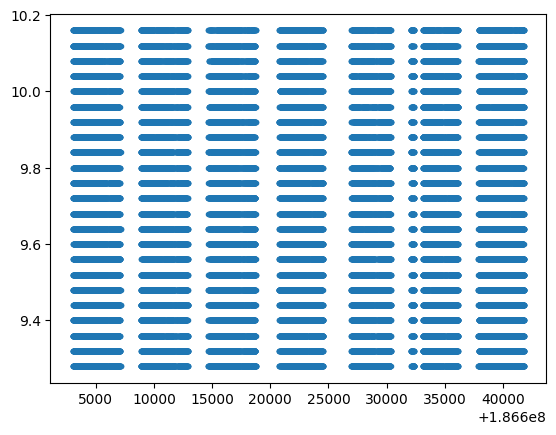

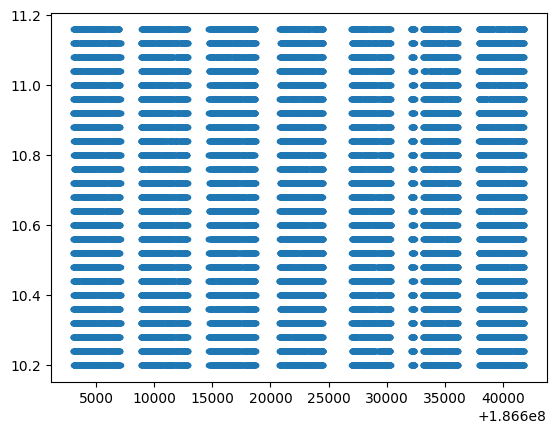

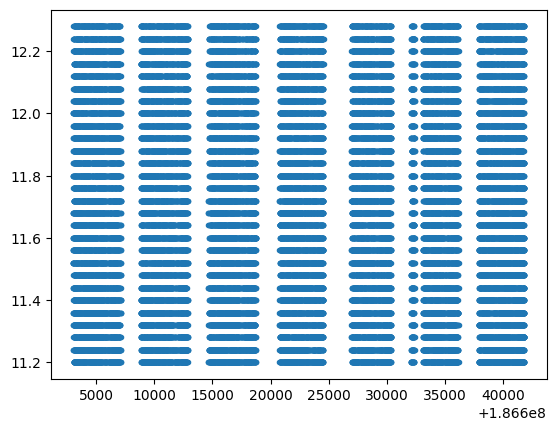

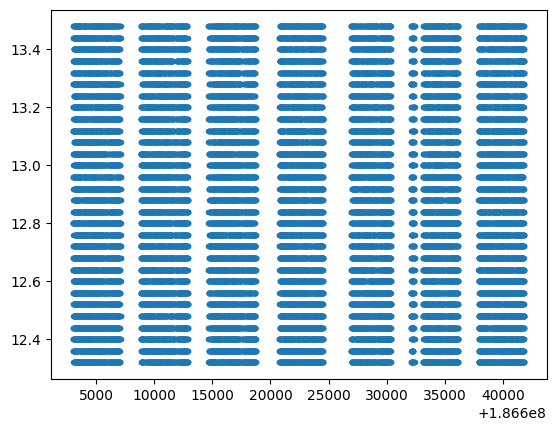

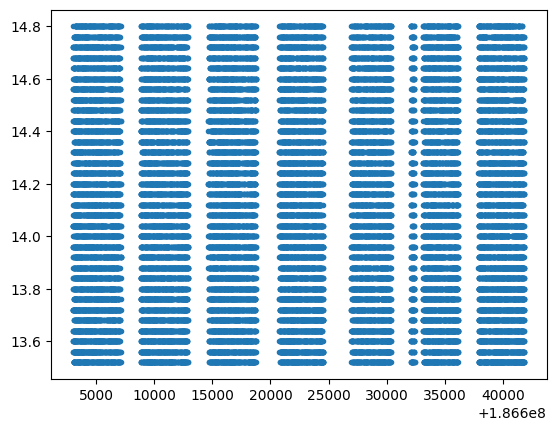

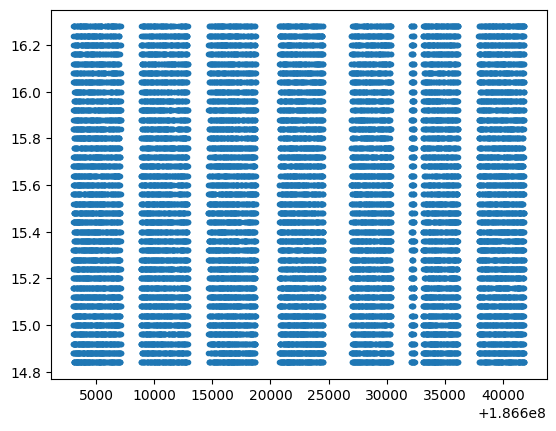

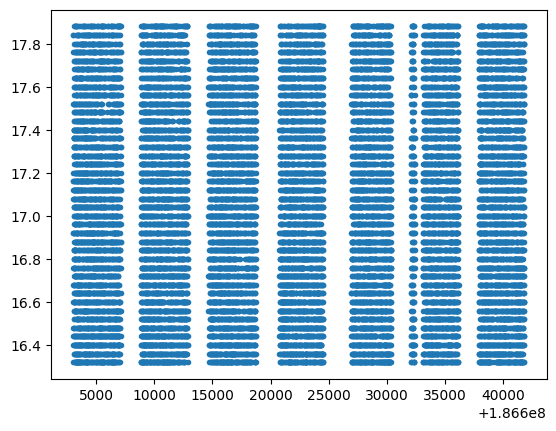

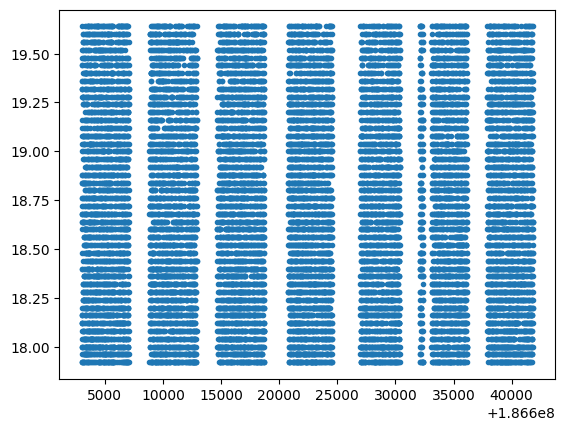

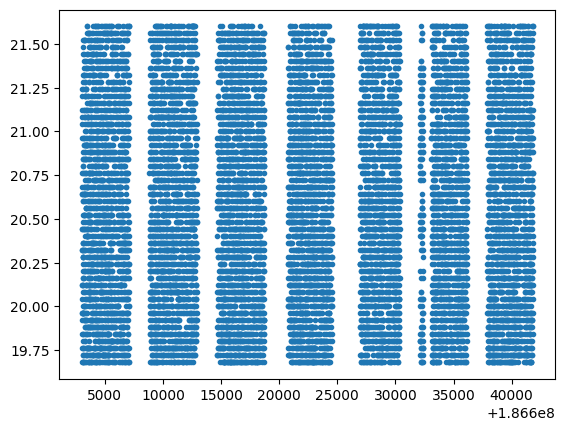

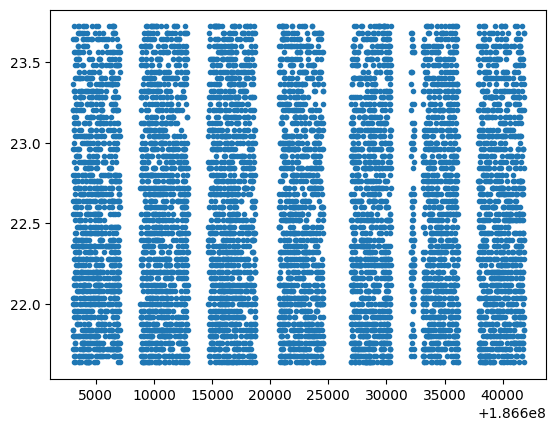

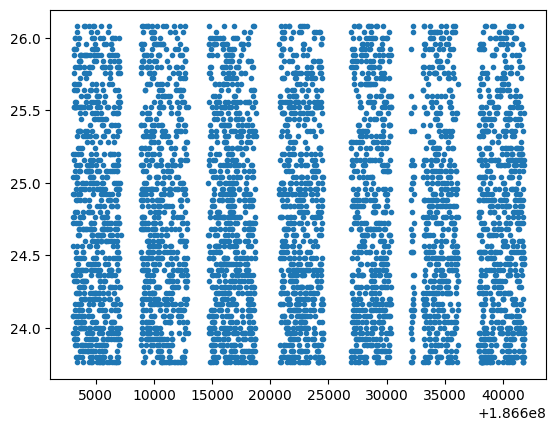

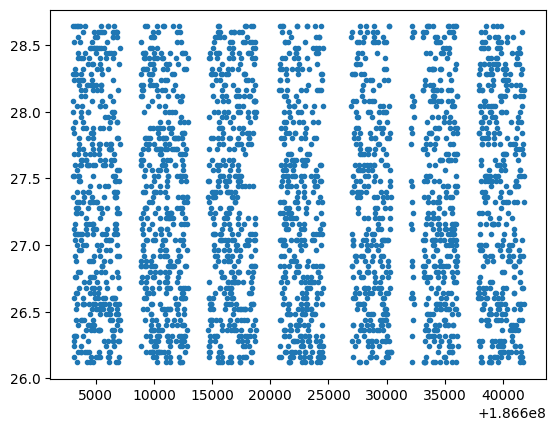

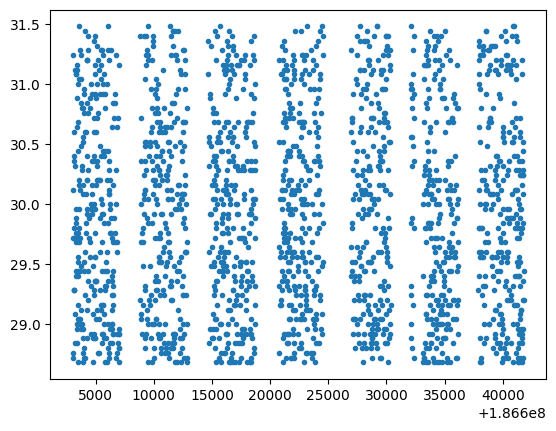

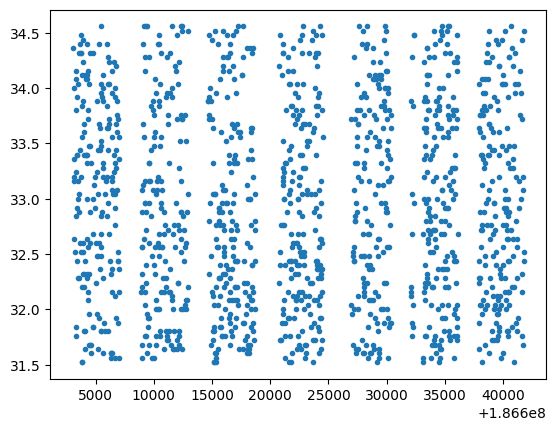

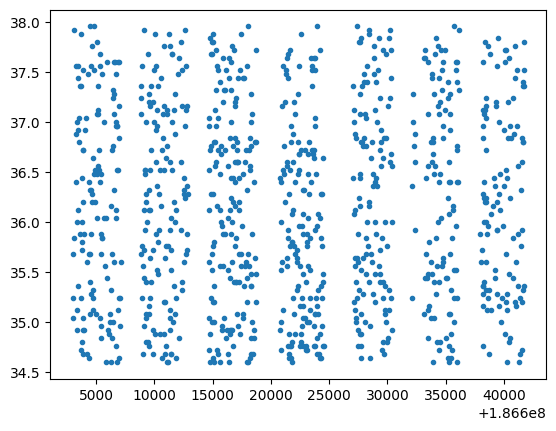

In [119]:
for i in range(np.abs(num_segments)):
    plt.plot(energy_time_segments[i], energy_segments[i], '.')
    plt.show()

## Plotting the energy pulse profile matrix 

8
13
8
11
14
14
10
14
13
10
10
9
11
10
7
3
10
3
3
28
22
3


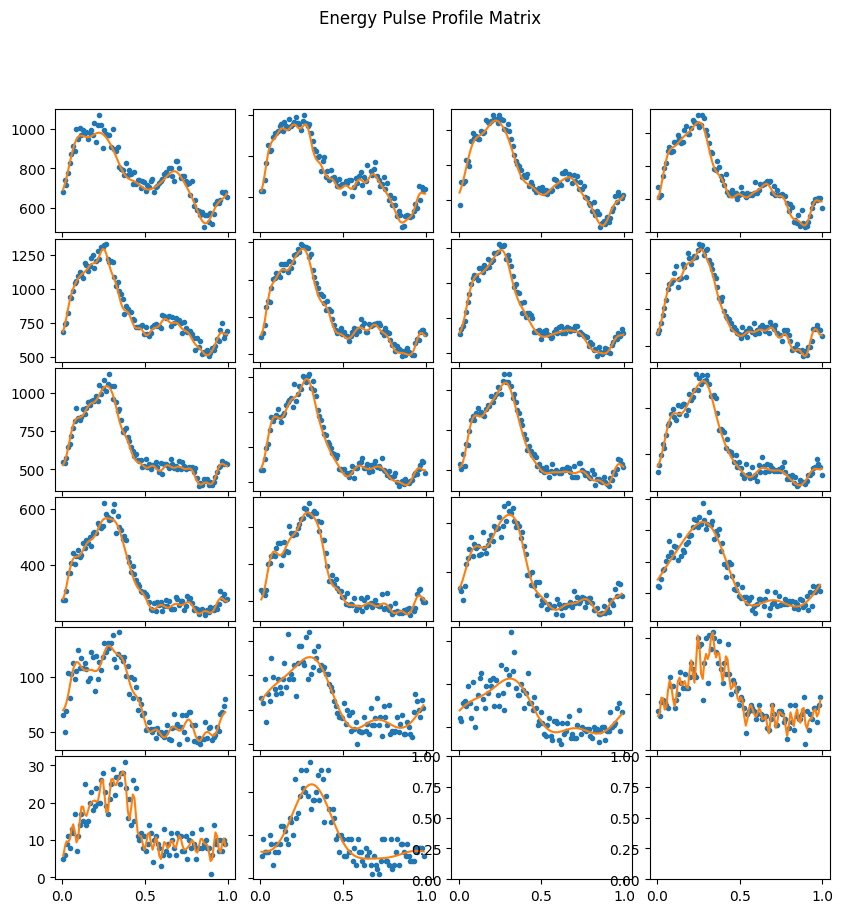

In [120]:
reload(IF)

energy_orders, energy_model_phases, energy_counts, energy_phasefold_time=IF.pulse_profile_matrix(energy_time_segments, 
                                                                                                 Time_phase_data['TIME'][0], 
                                                                                                 [guess_freq], 'Energy Pulse Profile Matrix', 0.01, 0.2)



In [121]:
print(len(energy_orders))

22


## Using bootstrap method to find the uncertainty on the phase 

## Re-making the bootstrapping method to be more general and calculating the phase and RMS for each energy pulse profile (i.e. making sure the new functions work)

In [122]:
reload(IF)
RMS_error = np.ones(len(energy_counts))
for i in range(len(energy_counts)):
    RMS_error[i] = IF.bootstrap_total(energy_counts[i], 1000, IF.RMS_calculator, energy_orders[i])
    print('RMS is:',IF.RMS_calculator(energy_counts[i], energy_orders[i]), ' +/- ', RMS_error[i])
    print('First phase is:', IF.get_first_harmonic_phase(energy_counts[i]), ' +/- ', IF.bootstrap_total(energy_counts[i], 100, IF.get_first_harmonic_phase)) 
    print('\n')

RMS is: 0.12164682556783056  +/-  0.0026073462119166405
First phase is: -1.5864119747097467  +/-  0.02956524667042326


RMS is: 0.1397982893440802  +/-  0.002656933398873923
First phase is: -1.5491489062946184  +/-  0.022480902744306183


RMS is: 0.1649093762535868  +/-  0.002722321024208753
First phase is: -1.5525569098750958  +/-  0.02089808748594237


RMS is: 0.17846616758004108  +/-  0.002748641668084028
First phase is: -1.5288548897929826  +/-  0.01607837539875041


RMS is: 0.18799007871921028  +/-  0.0026636352838998994
First phase is: -1.4949425806502552  +/-  0.013055706466238515


RMS is: 0.199242765856012  +/-  0.0027006969708620707
First phase is: -1.4960047392257392  +/-  0.014416439294482638


RMS is: 0.20902985235245977  +/-  0.002651022597449473
First phase is: -1.4894452327386487  +/-  0.014133543254643109


RMS is: 0.2132978170564512  +/-  0.002714961761996432
First phase is: -1.5103714905836685  +/-  0.012731111013974929


RMS is: 0.2186457966947117  +/-  0.0030518274

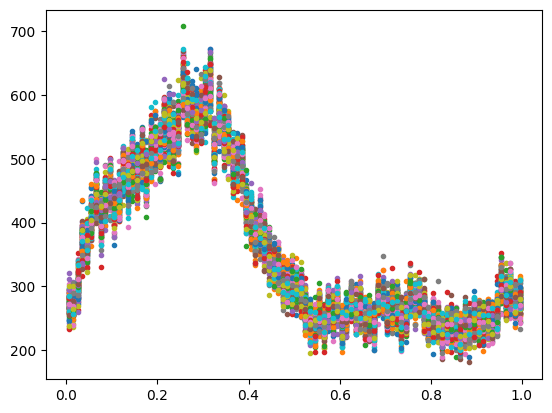

In [123]:
for i in range(100):
    plt.plot(energy_phasefold_time[12], IF.bootstrap_generate(energy_counts[12], 100)[i], '.')
plt.show()

## Plotting the RMS against energy 

Text(0.5, 1.0, 'Plot of the RMS against Energy for Bootstrap')

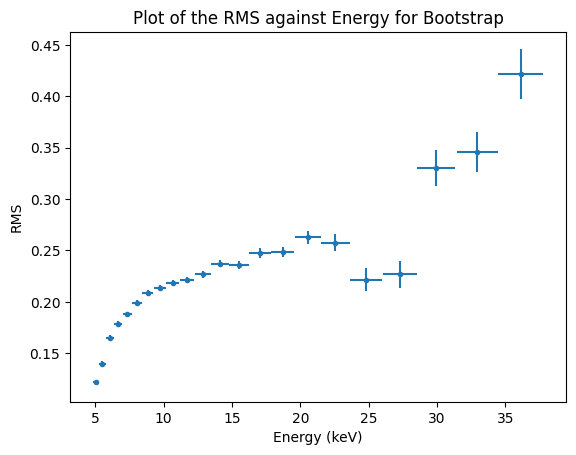

In [124]:
reload(IF)
RMSs = np.zeros(len(energy_counts))
RMS_error = np.ones(len(energy_counts))
E_rror = np.ones(len(energy_counts))
for i in range(len(energy_counts)):
    RMS_error[i] = IF.bootstrap_total(energy_counts[i], 1000, IF.RMS_calculator, energy_orders[i])
    RMSs[i] = IF.RMS_calculator(energy_counts[i], energy_orders[i])
    E_rror[i] = 0.5*(max(energy_segments[i])-min(energy_segments[i]))
    
fig, ax = plt.subplots(1, 1)
ax.errorbar(avg, RMSs, xerr=E_rror, yerr=RMS_error, fmt='.')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('RMS')
ax.set_title('Plot of the RMS against Energy for Bootstrap')

#plt.savefig('/Users/samsonmercier/Desktop/RMS_vs_Energy.pdf')